<a href="https://colab.research.google.com/github/S-276/AC_50001/blob/main/AC50001_BreastMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🩺 AC50001 – BreastMNIST Classification using Keras

### 🎓 Student Name: Siddharth Parikh  
### 🗂️ Module Code: AC50001  
### 📘 Dataset: BreastMNIST (Binary Classification)  
### 📅 Submission Date: 7th April 2025  

---

## 📌 Introduction

This notebook investigates binary image classification using the BreastMNIST dataset, which consists of grayscale ultrasound images (28×28 pixels) labeled as either **benign (0)** or **malignant (1)** tumors.

The aim is to evaluate three different neural network architectures using **Keras**:

1. **Model 1** – A baseline **Convolutional Neural Network (ConvNet)** inspired by the example notebook provided in class.
2. **Model 2** – A **dense-only model** with a similar parameter count, using no convolution layers.
3. **Model 3** – A **custom deep network** incorporating **data augmentation** and **regularization techniques** such as Dropout or L2.

The models will be assessed on their **accuracy**, **AUC**, and confusion matrices. Clear visualizations and analysis will guide the final conclusions. A time log is included to document time spent on the assignment.


In [ ]:
# Built-in Imports
import random

In [ ]:
# Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [ ]:
# Keras Imports
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import get_file, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Dataset Downloader
This section will download the selected [MedMNIST](https://medmnist.github.io/) dataset as a NumPy array object to your Google Colab instance.

To change the dataset that will download just change the variable DATA_NAME to desired dataset name.

All storage on a Google Colab instance is deleted when the instance ends so the dataset will need to be redownloaded each time an instance is created (Don't worry this usually takes about 20 seconds).

In [ ]:
DATA_NAME = "PathMNIST"

In [ ]:
!wget https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
from info import INFO
data = INFO[DATA_NAME.lower()]

--2025-04-05 12:41:35--  https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27766 (27K) [text/plain]
Saving to: ‘info.py’

info.py             100%[===================>]  27.12K  --.-KB/s    in 0.002s  

2025-04-05 12:41:35 (17.2 MB/s) - ‘info.py’ saved [27766/27766]



In [ ]:
# Downloads the dataset file hosted on Zenodo.
file_path = get_file(fname="dataset.npz",
                     origin=data["url"],
                     md5_hash=data["MD5"])

205615438/205615438 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [ ]:
# Loads the downloaded NumPy object.
dataset = np.load(file_path)

# Gets the training images and labels from the NumPy object.
train_x = dataset["train_images"]
train_y = dataset["train_labels"]

# Gets the validation images and labels from the NumPy object.
val_x = dataset["val_images"]
val_y = dataset["val_labels"]

# Gets the testing images and labels from the NumPy object.
test_x = dataset["test_images"]
test_y = dataset["test_labels"]

## Data Exploration
In this section we have a look at our data, their distributions to see if it is ready to be used within our machine learning algorithm.

In [ ]:
# Declares a list of labels.
labels = list(data["label"].values()) + ["total"]

# Gets the counts for each label in each of our datasets.
_, train_counts = np.unique(train_y, return_counts=True)
_, val_counts = np.unique(val_y, return_counts=True)
_, test_counts = np.unique(test_y, return_counts=True)

# Prints the counts for each label from each dataset.
print(pd.DataFrame(list(zip(np.append(train_counts, [sum(train_counts)]),
                            np.append(val_counts, [sum(val_counts)]),
                            np.append(test_counts, [sum(test_counts)]))),
                   index=labels, columns=["Train", "Val", "Test"]))

                                      Train    Val  Test
adipose                                9366   1041  1338
background                             9509   1057   847
debris                                10360   1152   339
lymphocytes                           10401   1156   634
mucus                                  8006    890  1035
smooth muscle                         12182   1354   592
normal colon mucosa                    7886    877   741
cancer-associated stroma               9401   1045   421
colorectal adenocarcinoma epithelium  12885   1432  1233
total                                 89996  10004  7180


44471: debris


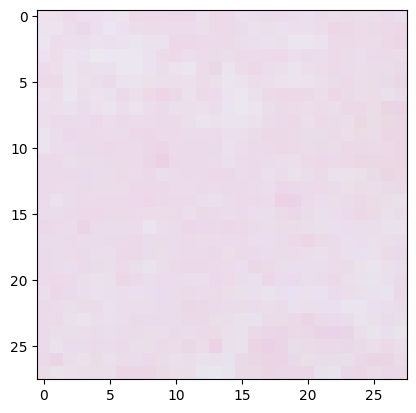

In [ ]:
# Displays a random image from training dataset.
index = random.randint(0, len(train_x))
print(f"{index}: {labels[train_y[index][0]]}")
plt.imshow(train_x[random.randint(0, len(train_x))])

## Data Processing
In this section we will create a data loader for algorithm that will dynamiclly load and augment the data when needed.

In [ ]:
# Defines the data generator that will be used to augment the images as they are loaded.
data_generator = ImageDataGenerator(featurewise_center=True,
                                    featurewise_std_normalization=True,
                                    horizontal_flip=True,
                                    vertical_flip=True)

In [ ]:
data_generator.fit(np.append(train_x, val_x, 0))

## Model Definition
In this section we will define the neural network arcitecture.

In [ ]:
# Define the input layer of the model with the size of an image.
input = layers.Input(shape=train_x[0].shape)

# Defines the first convolutional layer with max pooling.
conv_1 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(input)
pool_1 = layers.MaxPool2D(pool_size=(2, 2))(conv_1)

# Defines the second convolutional layer with max pooling.
conv_2 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(pool_1)
pool_2 = layers.MaxPool2D(pool_size=(2, 2))(conv_2)

# Flattens the outputs of the convolutoonal layers into a one dimensional array.
flatten = layers.Flatten()(pool_2)

# Defines the output layer of the model a number of output nodes equal to the number of classes.
output = layers.Dense(units=len(np.unique(train_y)), activation="softmax")(flatten)

# Initilises the defined model and prints summary of the model.
model = Model(inputs=input, outputs=output, name="Model")
model.summary()

Model: "Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 800)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 9)                   │           7,209 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,353 (67.79 KB)

 Trainable params: 17,353 (67.79 KB)

 Non-trainable params: 0 (0.00 B)

## Model Training
This is where we define the training options and then train the model.


In [ ]:
# Defines the parameters used during training.
BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

In [ ]:
# Defines the optimiser used to adjust the model weights and compiles the model.
optimiser = SGD(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimiser, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# We use the data generator to pass the training and validation data to the model to train it.
history = model.fit(data_generator.flow(train_x, to_categorical(train_y), batch_size=BATCH_SIZE),
                    steps_per_epoch=len(train_x) // BATCH_SIZE,
                    validation_data=data_generator.flow(val_x, to_categorical(val_y), batch_size=BATCH_SIZE),
                    validation_steps=len(val_x) // BATCH_SIZE,
                    epochs=NUM_EPOCHS)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1406/1406 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.2047 - loss: 2.1328 - val_accuracy: 0.2853 - val_loss: 1.8643
Epoch 2/10
   1/1406 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.3281 - loss: 1.9238

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1406/1406 ━━━━━━━━━━━━━━━━━━━━ 1s 618us/step - accuracy: 0.3281 - loss: 1.9238 - val_accuracy: 0.2887 - val_loss: 1.8623
Epoch 3/10
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.3280 - loss: 1.8005 - val_accuracy: 0.4240 - val_loss: 1.6160
Epoch 4/10
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 1s 588us/step - accuracy: 0.3594 - loss: 1.8139 - val_accuracy: 0.4303 - val_loss: 1.6167
Epoch 5/10
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.4381 - loss: 1.5542 - val_accuracy: 0.4674 - val_loss: 1.4273
Epoch 6/10
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 1s 610us/step - accuracy: 0.4531 - loss: 1.4232 - val_accuracy: 0.4654 - val_loss: 1.4346
Epoch 7/10
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.4824 - loss: 1.3889 - val_accuracy: 0.4944 - val_loss: 1.3384
Epoch 8/10
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 1s 902us/step - accuracy: 0.4688 - loss: 1.3682 - val_accuracy: 0.4879 - val_loss: 1.3476
Epoch 9/10
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5154 - loss: 1.3097 -

## Plot Learning Curves
This is where we visualise the training of the model.

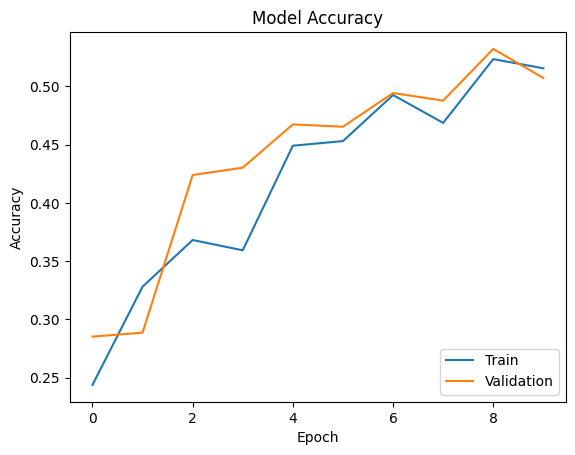

In [ ]:
# Plots the training and validation accuracy over the number of epochs.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

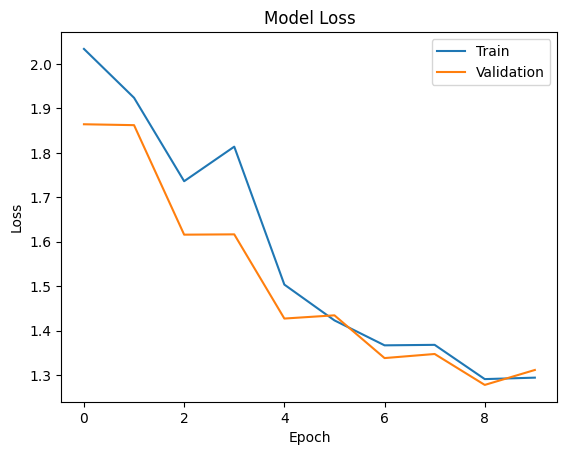

In [ ]:
# Plots the training and validation loss over the number of epochs.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()